In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import Audio

%matplotlib inline

## Creating mixtures

In [5]:
numMixtures = 2
numSources = 2
dur = 5 # duration of the signals in seconds 

fs1, source1 = wav.read('/Users/yu-jehliu/OneDrive/UIUC/ICA/SoundSources/news.wav')
fs2, source2 = wav.read('/Users/yu-jehliu/OneDrive/UIUC/ICA/SoundSources/mozart_vl_44k.wav')
s = np.asarray(np.vstack((source1[:dur*fs1], source2[:dur*fs2])))
A = np.random.uniform(size=(numMixtures, numSources))
x = (A @ s)

/Users/yu-jehliu/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


First Mixture

In [6]:
Audio(x[0], rate=fs1)

Second Mixture

In [7]:
Audio(x[1], rate=fs1)


## Preprocessing: Mean Subtraction

In [8]:
for i in range(numMixtures):
    mu = np.mean(x[i])
    x[i] -= mu

## Preprocessing: Second Order Statistics

In [9]:
# Setting the cavariance to be 0, variance to be 1
cov = (x[:,0].reshape(2,1) @ x[:,0].reshape(1,2)) / len(x[0])

for i in range(1,len(x[0])):
    cov += (x[:,i].reshape(2,1) @ x[:,i].reshape(1,2)) / len(x[0])

In [10]:
eigVal, V = np.linalg.eigh(cov)

inv_eigVal = np.zeros(eigVal.shape)
for i in range(len(eigVal)):
    inv_eigVal[i] = 1.0/eigVal[i]
    
D_negHalf = np.diag(np.sqrt(inv_eigVal))
x_tilde = V @ D_negHalf @ V.T @ x

##### Verify that $E[\tilde{x} \tilde{x}^T] = I$

In [11]:
covtilte = (x_tilde[:,0].reshape(2,1) @ x_tilde[:,0].reshape(1,2)) / len(x_tilde[0])

for i in range(1,len(x[0])):
    covtilte += (x_tilde[:,i].reshape(2,1) @ x_tilde[:,i].reshape(1,2)) / len(x_tilde[0])
print(covtilte)

[[  1.00000000e+00  -7.16554129e-15]
 [ -7.16554129e-15   1.00000000e+00]]


## Visualize the distribution of the mixture data $\tilde{x}$

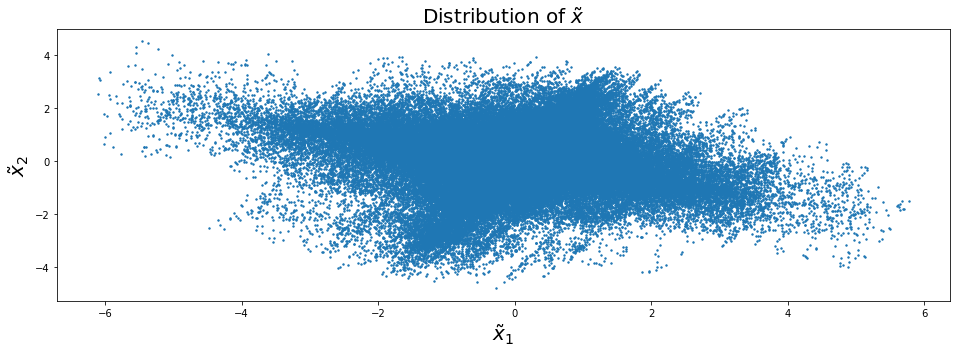

In [12]:
plt.figure(figsize=(16,5))
plt.scatter(x_tilde[0], x_tilde[1], s= 2)
plt.title(r'Distribution of $\tilde{x}$', fontsize=20)
plt.xlabel(r'$\tilde{x}_1$', fontsize=20)
plt.ylabel(r'$\tilde{x}_2$', fontsize=20)

# ICA: FastICA - One Unit 

#### Here, one unit refers to the fact that we are only estimating one unmixed source $u_i$ at a time.
#### Suppose that we have a unmixing matrix $W$, $n$ mixtures $x_i$ where $i=1,2,\cdots,n$. The components extracted will be $U=Wx$, where $U=\{u_1,u_2,\cdots,u_n\}$. Now because we would want to minimize the mutual information -> maximize the negentropy estimate for  $J(Wx)$ -> maximize each negentropy estimate $J(u_i)=J(w_i^Tx)$ 
#### Now, because we have the relationship $$J(y)\propto (E[G(y)] - E[G(v)])^2$$ 
#### where $y$ is a random variable with zero mean and unit variance, $G(\cdot)$ is a nonquadratic function, $v$ is a standardized Gaussian variable.
#### We can maximize the negentropy $J(u_i)$ by maximizing $(E[G(w_i^Tx)] - E[G(v)])^2$ for some properly chosen nonquadratic function $G(\cdot)$
#### Here, from Kuhn-Tucker conditions, under the constraint $E[(w^Tx)^2]=\|w\|^2=1$ (we want to maintain the unit variance), the maximum happens when 
$$E[x\cdot g(w^Tx)] - \beta w = 0$$
#### where $g(t)=\frac{\partial G(t)}{\partial t}$ 
#### Finding the root for the above equation using Newton's method, we can obtain the update formula as
$$w^{new} = E[x \cdot g(w^Tx)] - E[g'(w^Tx)]w$$

#### Here, using the chosen function $G(t)=-\text{exp}(-t^2/2)$ (proven to be one of the best functions to approximate the negentropy), we get
$$g(t) = t\cdot \text{exp}(-t^2/2)$$
$$g'(t) = \text{exp}(-t^2/2) - t^2 \cdot \text{exp}(-t^2/2)$$

In [50]:
# Define subroutines for g and g' for cleaner look to the proceeding code
def g(t):
    return (t * np.exp(-t**2/2))
def gPrime(t):
    return (np.exp(-t**2/2) - t**2 * np.exp(-t**2/2))

In [79]:
#First initialize a random mixing matrix row wT
wT = np.random.random((1,numMixtures))
wT /= np.linalg.norm(wT)

# Update the unmixing vector wT
conv = 0
iter_num = 0
beta = 1

# Iterating until convergence or until iteration number reaches 20 in this case
while ((not conv) and iter_num < 20):    
    # Initialize the first and the second expectation terms in the updating formula
    iter_num += 1
    wTold = wT
    FirstExp = 0.
    SecondExp = 0.
    for j in range(len(x[0])):
        arg = (wT @ x[:,j].reshape(numMixtures, 1))[0][0]
        FirstExp += x[:,j].reshape(1,numMixtures) * g(arg)
        SecondExp += gPrime(arg) 
    
    # Combining the two terms and use the updating formula for the new unmixing vector wT
    wT = FirstExp/ len(x[0])  - (SecondExp/ len(x[0]) * wT)
    # Normalizaing the new unmixing vector wT
    wT /= np.linalg.norm(wT)
    conv = ((1 - abs(np.sum(wTold*wT))) < 0.1)
    print('Iteration: %i ,Inner Product of wT_old and wT_new: %f \n' % (iter_num, abs(np.sum(wTold*wT))))

Iteration: 1 ,Inner Product of wT_old and wT_new: 0.559401 

Iteration: 2 ,Inner Product of wT_old and wT_new: 0.121611 

Iteration: 3 ,Inner Product of wT_old and wT_new: 0.405088 

Iteration: 4 ,Inner Product of wT_old and wT_new: 0.999929 



## Visualize the first direction computed using one unit FastICA

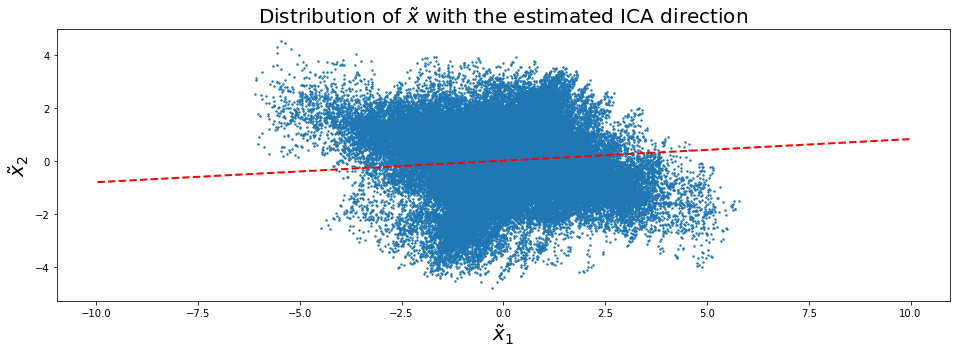

In [80]:
plt.figure(figsize=(16,5))
plt.scatter(x_tilde[0], x_tilde[1], s= 2)
plt.plot([-wT[0,0]*10, wT[0,0]*10],[-wT[0,1]*10, wT[0,1]*10], '--r',linewidth=2)
plt.title(r'Distribution of $\tilde{x}$ with the estimated ICA direction', fontsize=20)
plt.xlabel(r'$\tilde{x}_1$', fontsize=20)
plt.ylabel(r'$\tilde{x}_2$', fontsize=20)

## Obtain the one unit unmixed estimate

In [75]:
final_unmixed = wT @ x_tilde
Audio(final_unmixed, rate=fs1)